<a href="https://colab.research.google.com/github/Pratichhya/ubs_course/blob/main/Logistic%20Regression_sharma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical lab: Logistic Regression by using the gradient descent algorithm

## Utils

In [1]:
import os                               # working directory
import pandas as pd                     # data analysis
import matplotlib.pyplot as plt         # graphics
import numpy as np                      # maths
import sklearn.preprocessing            # data standardisation
from collections import Counter         # table frequency
import seaborn as sns

from scipy import stats                 # descriptive statistics
from sklearn import datasets            # data
from sklearn.linear_model import LogisticRegression    # Logistic Regression
from sklearn.model_selection import train_test_split # train and test samples
from sklearn.metrics import confusion_matrix # confusion matrix
from scipy import optimize              # optimisation algorithms


## Data

The data relates to a breast cancer clinical study conducted at the University of Winconsin. This is to predict the status of the tumor (malignant=1 or benign=0) from characteristics of cells taken from patients
* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* ···

Objective: to study the probability of having a malignant tumor depending on certain characteristics

The data was originally published by W.N. Street, W.H. Wolberg and O.L. Mangasarian. Nuclear feature extraction for breast tumor diagnosis. IS&T/SPIE 1993 International Symposium on Electronic Imaging : Science and Technology, volume 1905, pages 861-870, San Jose, CA, 1993.

The practical lab includes the following steps (you must fill in the different notebook cells)
* Import data
* Build the necessary functions: f, cost, gradient then implement the gradient descent algorithm (some functions are identical to those produced in the case of the linear regression)
* Test for the case of simple logistic regression
* Then extend the test to multiple logistic regression
* Return the model coefficients and the values of the cost function for all iterations
* Vary the parameters of the algorithm (initialization, learning rate) and comment.
* Compare with native Python optimization solutions (no exact solution here)

In [2]:
#-- Data import
breast_cancer = datasets.load_breast_cancer()
#print(breast_cancer.DESCR)
#Data Set Characteristics:
#    :Number of Instances: 569
#
#    :Number of Attributes: 30 numeric, predictive attributes and the class
#
#    :Attribute Information:
#        - radius (mean of distances from center to points on the perimeter)
#        - texture (standard deviation of gray-scale values)
#        - perimeter
#        - area
#        - smoothness (local variation in radius lengths)
#        - compactness (perimeter^2 / area - 1.0)
#        - concavity (severity of concave portions of the contour)
#        - concave points (number of concave portions of the contour)
#        - symmetry
#        - fractal dimension ("coastline approximation" - 1)
#
#        The mean, standard error, and "worst" or largest (mean of the three
#        largest values) of these features were computed for each image,
#        resulting in 30 features.  For instance, field 3 is Mean Radius, field
#        13 is Radius SE, field 23 is Worst Radius.
#
#        - class:
#                - WDBC-Malignant
#                - WDBC-Benign

In [3]:
#-- Descriptive stat
dat = breast_cancer.data            #features associated with cancer
Y = breast_cancer.target            #malignant save as 1 and benign as 0
names = breast_cancer.feature_names

#%% Stat descriptives
df=pd.DataFrame(dat)
y=pd.DataFrame(Y)                 # changing numpy array to dataframe to use and know correlation 
df.columns=names                  # to add column names
DF=df.to_numpy()                  #dataframe to numpy array

cor_results=df.corrwith(y[0])     #checking the correlation of y with several variable of df
print(cor_results)

mean radius               -0.730029
mean texture              -0.415185
mean perimeter            -0.742636
mean area                 -0.708984
mean smoothness           -0.358560
mean compactness          -0.596534
mean concavity            -0.696360
mean concave points       -0.776614
mean symmetry             -0.330499
mean fractal dimension     0.012838
radius error              -0.567134
texture error              0.008303
perimeter error           -0.556141
area error                -0.548236
smoothness error           0.067016
compactness error         -0.292999
concavity error           -0.253730
concave points error      -0.408042
symmetry error             0.006522
fractal dimension error   -0.077972
worst radius              -0.776454
worst texture             -0.456903
worst perimeter           -0.782914
worst area                -0.733825
worst smoothness          -0.421465
worst compactness         -0.590998
worst concavity           -0.659610
worst concave points      -0

<p style='text-align: justify;'>When the correlation between two target and feature dataframes was computed, it was discovered that the majority of features were negatively correlated, with very little positive correlation with others. So, based on these values, three features were chosen that had a high negative correlation, assuming that when there is a high worst parameter, it is expected that the cancer corresponding to that feature will not exist, and vice versa.</p>





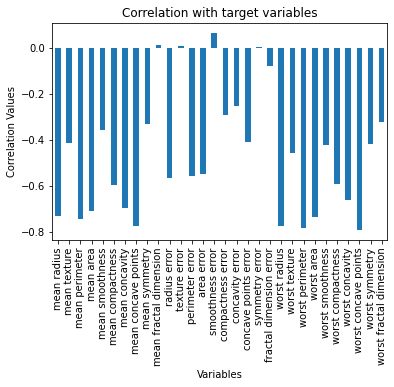

In [4]:
#correlation plot between y and main dataframe
cor_results.plot(kind='bar', title='Correlation with target variables',xlabel='Variables',ylabel='Correlation Values')

Text(0, 0.5, 'worst concave points')

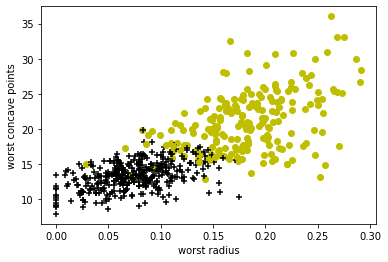

In [5]:
# Plotting available data based on most correlated variables

x_plot = np.vstack((np.asarray(df['worst concave points'].values), \
               np.asarray(df['worst radius'].values)))
y_plot = np.asarray(y.values)


# Plot the data
for i in range(len(y_plot)):
    if y_plot[i]==0.0:
        c = 'y'
        m = u'o'                #yellow dot classified as benign
    if y_plot[i]==1.0:
        c = 'black' 
        m = u'+'                #+ black classsified as malignant
    plt.scatter(x_plot[0][i], x_plot[1][i], color=c, marker=m)
    
# plotting
plt.xlabel(df.columns[df.columns.get_loc("worst radius")])
plt.ylabel(df.columns[df.columns.get_loc("worst concave points")])

In [6]:
# Some stats with Counter
Counter(Y)                  # nb of cases / controls
df.groupby(Y).mean()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,0.062680,0.609083,1.210915,4.323929,72.672406,0.006780,0.032281,0.041824,0.015060,0.020472,0.004062,21.134811,29.318208,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530
1,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,0.062867,0.284082,1.220380,2.000321,21.135148,0.007196,0.021438,0.025997,0.009858,0.020584,0.003636,13.379801,23.515070,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442


In [7]:
Xs = df['worst concave points']                                     #for simple logistic regression
Xm = df[['worst concave points','worst perimeter','worst radius']]  #for multiple logistic regressn

#-- Checking the size of both matrices
print(Xs.shape)
print(Xm.shape)

(569,)
(569, 3)


In [8]:
#-- Buils Xs and Xm for simple and multiple logistic regresstion
Xs = Xs.to_numpy()    #dataframe to numpy
Xm = Xm.to_numpy()    

## Logistic regression by using the gradient descent algorithm


As per my understanding, we chose to work with logistic regression for cases where linear regression fails to classify the results into specific targets, instead, it will predict a numerical value associated with it. But, this might not be the case always, as herein logistic regression we are trying to classify the new dataset to either of the two classes. 

In [9]:
def standardisation(x):
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0, ddof=1)     #we have kept ddof=1 as it is for sample data else in case of python they have kept default to 0 as for population data  
    n = ((x-mean)/std)                  # based on the equation((mean-x)/standard deviation)                    
    return n
# normalizing the values
Xs_norm = standardisation(Xs)           
Xm_norm = standardisation(Xm)           
print(stats.describe(Xm_norm))

DescribeResult(nobs=569, minmax=(array([-1.7435287 , -1.69187236, -1.72538237]), array([2.68351581, 4.28356837, 4.09059011])), mean=array([-1.73265034e-16, -1.21441619e-15, -2.34610222e-15]), variance=array([1., 1., 1.]), skewness=array([0.49131594, 1.12518762, 1.10020504]), kurtosis=array([-0.54136707,  1.05024268,  0.9252876 ]))


In [10]:
xs = np.c_[np.ones((Xs_norm.shape[0], 1)), Xs]      #adding 1 vector column
xm = np.c_[np.ones((Xm_norm.shape[0], 1)), Xm]
ys = Y[:, np.newaxis]                               #making Y two-dimensional to match the dimensions.

In [11]:
ys.shape

(569, 1)

As we know the logistic regression model equation is: $h_\theta(x)=g(\theta^Tx)$ where $g$ is a sigmoid function that uses the product of $\theta$ vector and $x$ vector. The function gives the probability result will either be 0 or 1. The function when implemented in python is:

$$h_\theta(x)=\frac{1}{1+e^{(\theta^Tx)}}$$

In [12]:
#-- Model
# be careful: X contains X_0 = [1,...,1] + X_j
#defining the sigmoid function

def sigmoid(x, theta):
  z = np.dot(x, theta)
  return 1/(1+np.exp(-z))

#Using this sigmoid function to write the hypothesis function that will predict the output:

def hypothesis(theta, x):
  return sigmoid(x, theta)


Now to choose the parameter $\theta$ with logistic regression, we calculated the cost function to optimize the search using gradient descent using the formula: 
$$J(\theta)=\frac{1}{2m}\sum_{i=1}^{m}[(h_\theta(x)-y)^2]$$

and it case of python it can be interpreted as:
$$Cost(h_\theta(x),y)=\Bigg\{\begin{align*}
	-log&(h_\theta(x)) & if&&y=1\\
	-log&(1-h_\theta(x)) & if&& y=0\\
	\end{align*}$$

In [13]:
#-- Cost function
def cost(theta,x,y):
  m = x.shape[0]
  h = hypothesis(theta, x)
  return -(1/m)*np.sum(y*np.log(h) + (1-y)*np.log(1-h))

In [14]:
#-- Gradient

def grad(theta, x, y):
  m = x.shape[0]
  h = hypothesis(theta, x)
  return (1/m) * np.dot(x.T, (h-y))


## Experiment with several initialisations: visualisation of the cost function and parameter values during the iterations

Similar to linear regression, the Gradient Descent, is  included in the methodology which is an algorithm that calculates the derivative of the Cost Function, updating the vector $\theta$ by mean of the parameter $\alpha$, that is the learning rate. Gradient function that is implemented here looks identical to that used for the Linear Regression. But, as for the Cost Function, the difference is in the definition of $h_\theta(x)$ that needs the sigmoid function:

Repeated and kept updating $\theta$:
$$\theta_0(new)=\theta_0(old)-\alpha\frac{1}{m}\sum_{i=1}^{m}[(h_\theta(x^{(i)})-y^{(i)}]$$

In [15]:
#gradient descent algorithm
from tqdm.notebook import tqdm
def grad_descent(x,y,theta,alpha,itre):                                    #size of observations
    theta_val = np.zeros((itre,x.shape[1]))                      #list to store the beta values and cost values
    cost_val = np.zeros((itre))

    #calculate the theta values for each iteration
    for i in range(itre):
        
        theta=theta-alpha*(grad(theta, x, y) )                 #B(k)=B(k-1)-learning_rater*derivative of cost function i.e grad 
        theta_val[i,:] = theta.flatten()                         #update beta value
        costs = cost(theta,x,y)   
        #print(costs)#call the cost function for different beta values over iteration

        cost_val[i] = costs.flatten()
        if i>2 and cost_val[i-1]-costs<0.0000001:         #condition implemented for breakdown of the loop
            #print(f'diverged in iteration {i}')
            break
    return theta, theta_val, cost_val

## Experiment with several learning rate: visualisation of the cost function and parameter values during the iterations

In [16]:
theta_shape=xs.shape[1]
alpha = 0.009                                                 # Learning Rate
iter = 5000                                                         #number of iteration tested on

theta = np.random.randn(theta_shape,1)                              #initializing randome values
#calling gradient descent function
theta,theta_val,cost_val = grad_descent(xs,ys,theta,alpha,iter)      #calling gradient descent function for simple logistics regression
optimum_value = theta_val[len(cost_val)-1]
print("for simple logistics regression with alpha=0.009: ",optimum_value)

#different learning rate

alpha_2 = 0.03                                                # Learning Rate

theta_2 = np.random.randn(theta_shape,1)                              #initializing randome values
#calling gradient descent function
theta_2,theta_val_2,cost_val_2 = grad_descent(xs,ys,theta_2,alpha_2,iter)      #calling gradient descent function for simple logistics regression
optimum_value_2 = theta_val_2[len(cost_val_2)-1]
print("for simple logistics regression with alpha=0.03: ",optimum_value_2)

for simple logistics regression with alpha=0.009:  [ 0.68594659 -1.5288491 ]
for simple logistics regression with alpha=0.03:  [ 0.77426372 -2.28383272]


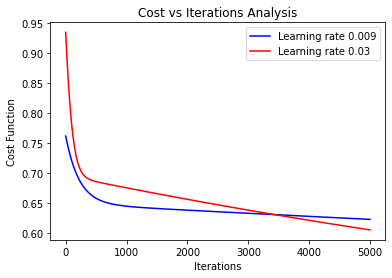

In [17]:
# Plotting Line Plot for Number of Iterations vs MSE
plt.plot(range(len(cost_val)),cost_val,'b',label ='Learning rate 0.009')
plt.plot(range(len(cost_val_2)),cost_val_2,'r',label ='Learning rate 0.03')
plt.xlabel('Iterations')
plt.ylabel('Cost Function')
plt.title('Cost vs Iterations Analysis')
plt.legend()
plt.show()

From the above plot of cost vs iteration we see that when learning rate is increased cost of the function is low and achive its optimum state very soon than in comparison to the one with lower learning rate. 

Though better details were captured when taking the smaller learning rate, the cost for such setting was relatively more.

In [47]:
#for multiple regression
theta_shape = xm.shape[1]
alpha_m = 0.0000009                                                      # Learning Rate
iter = 50000                                                           #number of iteration tested on
theta_m = np.random.randn(theta_shape,1)                                #initializing randome values
#calling gradient descent function
theta_m,theta_val_m,cost_val_m = grad_descent(xm,ys,theta_m,alpha,iter)      
optimum_value_m =theta_val_m[len(cost_val_m)-1]
print("for multiple linear regression with aplha 0.00009: ",optimum_value_m)


for multiple linear regression with aplha 0.00009:  [0. 0. 0. 0.]


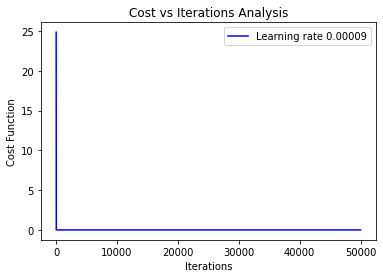

In [48]:
# Plotting Line Plot for Number of Iterations vs MSE
plt.plot(range(len(cost_val_m)),cost_val_m,'b',label ='Learning rate 0.00009')
plt.xlabel('Iterations')
plt.ylabel('Cost Function')
plt.title('Cost vs Iterations Analysis')
plt.legend()

The cost function in case of multiple logistic regression was difficult to implement. I wasn't able to make the decision for the reason behind the unusual curve. Still, I assumed that the reason behind this could be due to requirement of very small learning rate else the optimum point was skipping very quick and I wasn't able to capture the point.

Then, in the next step an optimization function was imported that optimized the value of theta. Here, the optimization function is used to optimize is the cost function.

In [30]:
#the fit function which will be used to find the model parameters that minimizes the cost function.
from scipy.optimize import minimize,fmin_tnc
def fit(x, ys, theta):
    opt_weights_chk = fmin_tnc(func=cost, x0=theta, fprime=grad, args=(x, ys.flatten()))
    return opt_weights_chk[0]
parameters = fit(xs, y, theta)      # to use these parameters as the theta values and the hypothesis function to calculate the final hypothesis.

h_chk = hypothesis(parameters, xs)

The above scripts fits the gradient function created in the previous step to compare the accuracy with that of pre-existing scikit logistic regression method.

In [25]:
#Using the hypothesis to predict the output variable
def predict(h):
    h1 = []
    for i in h:
        if i>=0.5:                      #predicted outcome with value greater than 0.5 is rounded off to 1
            h1.append(1)
        else:
            h1.append(0)                #predicted outcome with value less than 0.5 is rounded off to 0
    return h1
y_pred_chk = predict(h_chk)

In [26]:
#calculating the accuracy of the function created from scratch
accuracy = 0
for i in range(0, len(y_pred_chk)):
    if y_pred_chk[i] == ys[i]:
        accuracy += 1
print("accuracy of the logistic regression model created from scratch:" ,accuracy/len(y))

accuracy of the logistic regression model created from scratch: 0.9086115992970123


#Ridge regression

• Implement ridge regression by changing the functions that you have
implemented during the second lab session.

• Study the sensitivity of ridge regression to the regularisation
hyperparameter λ. Comment the results.

#Comparison of regularization techniques

• Use Python methods to compare the results of the three regularization
techniques: ridge regression, LASSO, and ElasticNet

• Tune the lambda hyperparameter value by using a cross-validation
procedure.

• Evaluate the performance of the linear regression algorithm


To solve the overfitting problem of the model, regularization was focused. The main concept behind the regularization was to measure the magnitude of weight cofficient usin two main penalty approach namely (L1 norm for ridig) and (L2 for lasso).

where **L1norm**:sum of absolute values$$||W||=|W_0|+|W_1|+....+|W_n|$$
and where **L2norm**:sum of squares$$||W||^2=W_0^2+W_1^2+....+W_n^2$$ 

In [34]:
#creating training and testing set
xs_train,xs_test,ys_train,ys_test = train_test_split(xs,y)
xm_train,xm_test,ym_train,ym_test = train_test_split(xm,y)

In [35]:
#Using Lasso as penalty
from sklearn import linear_model
# Analyzing the results. 
from sklearn import metrics

clf_lasso = linear_model.LogisticRegression(penalty='l2', solver='liblinear',tol=1e-6, max_iter=int(1e6), warm_start=True,intercept_scaling=10000.)
clf_lasso.fit(xs_train,ys_train)
y_pred_lasso = clf_lasso.predict(xs_test)
conf_matr_lasso = metrics.confusion_matrix(ys_test, y_pred_lasso)
conf_matr_lasso

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[22, 40],
       [ 0, 81]])

In [36]:
print("Accuracy from lasso penalty:",metrics.accuracy_score(ys_test, y_pred_lasso))

Accuracy from lasso penalty: 0.7202797202797203


In [37]:
#using Ridge ridge as penalty to fit a model

clf_ridig = linear_model.LogisticRegression(penalty='l1', solver='liblinear',tol=1e-6, max_iter=int(1e6),warm_start=True,intercept_scaling=10000.)
clf_ridig.fit(xs_train,ys_train)
y_pred_ridig = clf_ridig.predict(xs_test)
conf_matr_rigid = metrics.confusion_matrix(ys_test, y_pred_ridig)
conf_matr_rigid

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[54,  8],
       [ 2, 79]])

In [38]:
print("Accuracy from ridge penalty:",metrics.accuracy_score(ys_test, y_pred_ridig))

Accuracy from ridge penalty: 0.9300699300699301


In [39]:
clf_els = linear_model.ElasticNet(random_state=0)
clf_els.fit(xs_train,ys_train)
y_pred_els = clf_els.predict(xs_test)
print("Accuracy from elasticnet:",metrics.accuracy_score(ys_test, np.where(y_pred_els<0.5,0,1)))

Accuracy from elasticnet: 0.5664335664335665


It was observed that accuracy with **Accuracy from elasticnet: 63.63%**, **Accuracy from ridge penalty: 92.30%** and **Accuracy from lasso penalty: 83.91%**. This shows that the model is better fitted with Ridge penalty when compared with the other two.

 **Tuning the lambda hyperparameter value by using a cross-validation**

In [40]:
from sklearn.model_selection import KFold, RandomizedSearchCV,GridSearchCV
model = LogisticRegression()
# model.fit(xs_train,ys_train)
# model.predict(xs_test)

Here, I divided the data into 5 fold for cross validation that will be taking 4 folds for training and 1 for testing/validating set for each run.


In [41]:
kfold = sklearn.model_selection.KFold(n_splits=5,random_state=0)
model = LogisticRegression(C=5,penalty='l2')
results = sklearn.model_selection.cross_val_score(model,xs,y, cv=kfold)
print('Accuracy with 5 Kfolds:', results.mean()*100)

Accuracy with 5 Kfolds: 88.76106194690266


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ),

Accuracy of this model was showed as **88.76%** when performing cross validation without tuning the parameters.

In [42]:
#increasing the hyperparameter n_split
kfold_10 = sklearn.model_selection.KFold(n_splits=10,random_state=0)
model_10 = LogisticRegression(C=5,penalty='l2')
results_10 = sklearn.model_selection.cross_val_score(model_10,xs,y, cv=kfold_10)

#decreasing the hyperparamters n_split
kfold_3 = sklearn.model_selection.KFold(n_splits=3,random_state=0)
model_3 = LogisticRegression(C=5,penalty='l2')
results_3 = sklearn.model_selection.cross_val_score(model_3,xs,y, cv=kfold_3)
print('Accuracy with 10 Kfolds:', results_10.mean()*100)
print('Accuracy with 3 Kfolds:', results_3.mean()*100)

Accuracy with 10 Kfolds: 90.34147869674186
Accuracy with 3 Kfolds: 87.70723104056438


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ),

It was observed that:

$$ Accuracy {\space}with{\space} 10 Kfolds: 90.34{\%}$$
$$ Accuracy {\space}with{\space}3 Kfolds: 87.71{\%}$$

This suggests that the more the number of folds, the more is the accuracy but less is the value of error due to bias but increasing the error due to variance will increase; the more folds you have, the longer it would take to compute it and you would need more memory. With a lower number of folds, we’re reducing the error due to variance, but the error due to bias would be bigger.

**Evaluating the best regularization algorithm for my model**

In [43]:
logistic = LogisticRegression(solver='saga')

#creating a list of known penalty that can be used for testing
penalty = ['l1','l2']

#creating a list of different C values and taking it as a hyperparameter
C = np.linspace(1,100)

#creating dictionary to hold different values
hyperparameter = dict(C=C,penalty=penalty)

#fitting the model using gridsearch
clf_cv = GridSearchCV(logistic,hyperparameter,cv=5,verbose=0)
best_model = clf_cv.fit(xs,y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [44]:
#printing the model with best value of C and penalty
print(best_model.best_estimator_.get_params())

{'C': 9.081632653061224, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


The above outcome shows that the model is best fit for C=9.08 with L2 penalty i.e with lasso penalty which opposes the result that was achieved in previous step of obtaining better accuracy for Rigid than of Lasso.

#Conclusion



*   Logistic Regression is a generalized Linear Regression in the sense that we don’t output the weighted sum of inputs directly, but we pass it through a function that can map any real value between two or more classes.
* The result obtained from the model parameters from scikit is significantly different from the model that was implemented from scratch as, in case of python package, Logistic regression takes regularization into account that gives better accuracy for the model. 

Finally it was observed that:
* **Accuracy of the logistic regression model created from scratch: 90.86%**
* **Accuracy of model from Scikit with 5 Kfolds in Cross-validation: 88.76%**
* **Accuracy from regularization with elasticnet: 63.63%**
* **Accuracy from regularization with ridge penalty: 92.30% and**
* **Accuracy from regularization with lasso penalty: 83.91%**








```
Thank You
```

